# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_6_feat_eng_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_balancing_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.05
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)



 
target='returning_user'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363410 entries, 0 to 363409
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   event_name                       363410 non-null  float64
 1   device_category                  363410 non-null  float64
 2   device_mobile_model_name         363410 non-null  float64
 3   device_operating_system          363410 non-null  float64
 4   device_operating_system_version  363410 non-null  float64
 5   device_language                  363410 non-null  float64
 6   device_web_info_browser          363410 non-null  float64
 7   device_web_info_browser_version  363410 non-null  float64
 8   geo_region                       363410 non-null  float64
 9   geo_city                         363410 non-null  float64
 10  traffic_source_medium            363410 non-null  float64
 11  traffic_source_source            363410 non-null  float64
 12  engagem

In [5]:
test.columns

Index(['event_name', 'device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'geo_country',
       'session_engaged', 'year', 'quarter', 'is_weekend', 'domain',
       'returning_user'],
      dtype='object')

# Balancing Analysis

Minority class= 1.0 : 94199
Majority class= 0.0 : 269211
Original class distribution:
returning_user
0.0    74.079139
1.0    25.920861
Name: proportion, dtype: float64



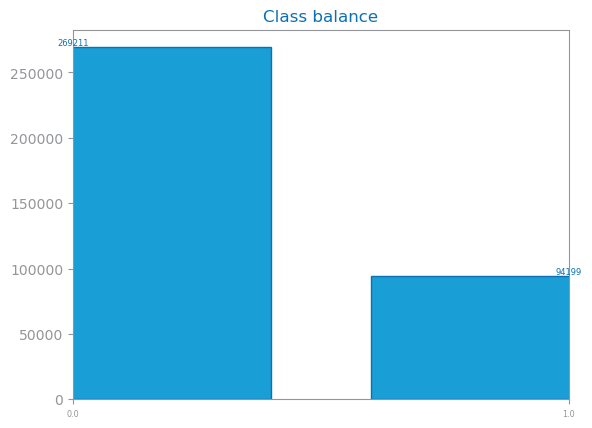

In [6]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

print(f"Original class distribution:\n{data[target].value_counts(normalize=True) * 100}\n")


figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling

## Bal 1 strategy Application

In [7]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    df_balanced=apply_balanced_downsampling(df_copy,sort_by='day_of_year')
    
    return df_balanced


train_1=apply_strategy_1(train)
test_1=test.copy()



Original class distribution:
returning_user
0.0    73.382183
1.0    26.617817
Name: proportion, dtype: float64

Balanced class distribution:
returning_user
1.0    50.0
0.0    50.0
Name: proportion, dtype: float64



## Bal 1 train/test split 

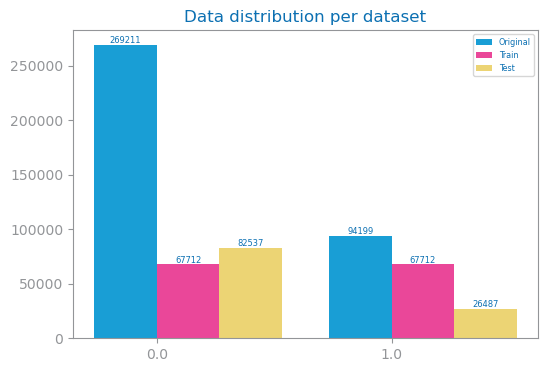

In [8]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 1 evaluate

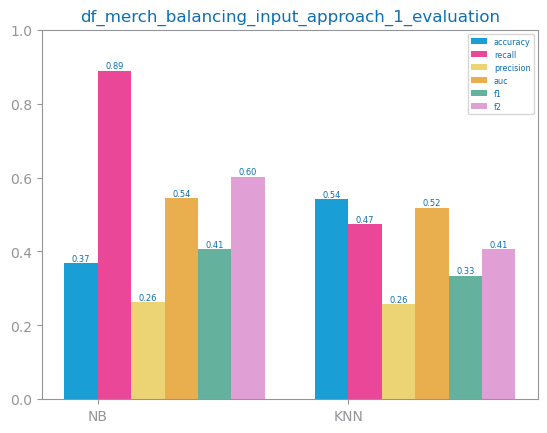

In [9]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='returning_user', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Bal 2 - Hybrid Sampling

Reduce from negative class from 75% and then oversample the positives into making a 60/40 ratio


## Bal 2 strategy aplication

In [10]:


def apply_strategy_2(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    df_balanced=apply_balanced_hybrid(df_copy,target='returning_user',minority_ratio=0.5,sort_by='day_of_year')

    return df_balanced


train_2=apply_strategy_2(train)
test_2=test.copy()


Original class distribution:
returning_user
0.0    73.382183
1.0    26.617817
Name: proportion, dtype: float64

Hybrid class distribution (50.0/50.0):
returning_user
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 2 distribution check

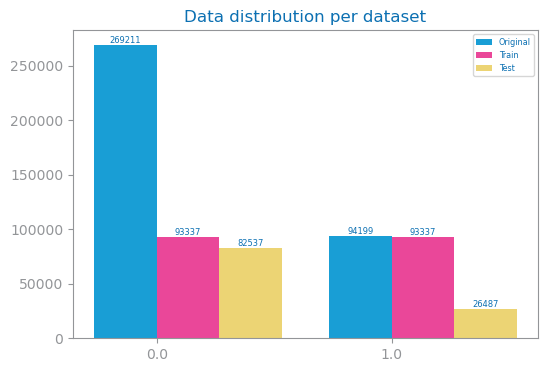

In [11]:
if evaluate==True:

    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 2 evaluate

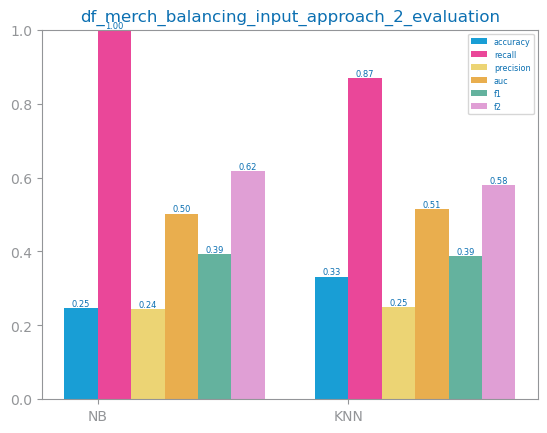

In [12]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='returning_user', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# Bal 3 - SMOTE

## Bal 3 strategy application

In [13]:

def apply_strategy_3(df):

    # Create a copy of the dataframe
    df_copy = df.copy()

    df_smote=apply_balanced_smote(df_copy,target=target,sort_by='day_of_year')


    return df_smote


train_3=apply_strategy_3(train)
test_3=test.copy()


Original class distribution:
returning_user
0.0    73.382183
1.0    26.617817
Name: proportion, dtype: float64

New class distribution:
returning_user
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 3 distribution

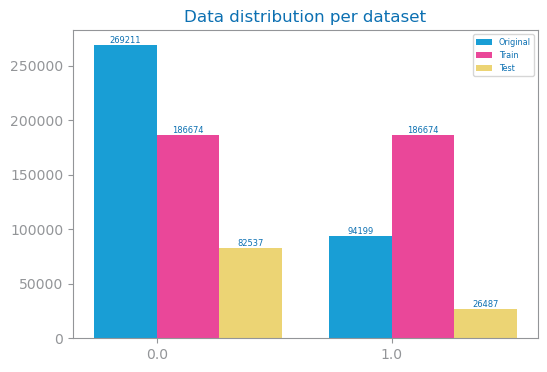

In [14]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_3[train_3[target] == 0]),
        len(train_3[train_3[target] == 1]),
    ]
    values["Test"] = [
        len(test_3[test_3[target] == 0]),
        len(test_3[test_3[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 3 evaluate

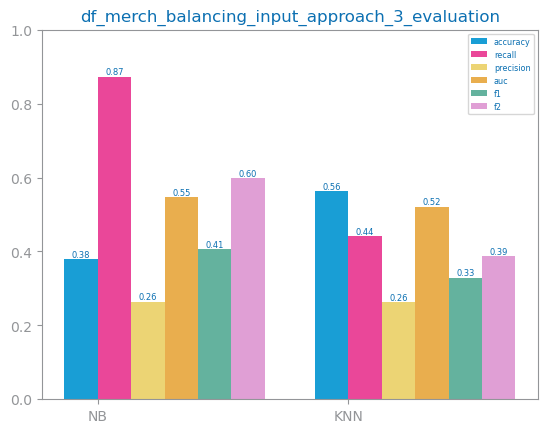

In [15]:
if evaluate == True:
    figure()
    eval_3: dict[str, list] = evaluate_approach(train_3, test_3, target='returning_user', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_3, title=f"{file_tag}_approach_3_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_3_evaluation.png")
    show()

# Approach uplift comparison

## uplift df

In [16]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)
df_eval_3 = pd.DataFrame(eval_3, index=algorithms)

# Calculate uplift
# df_uplift = df_eval_2 - df_eval_1

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_eval_3], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Undersampling', 'Hybrid', 'SMOTE'], eval_1.keys()])



# Display the DataFrame
comparison_df

Undersampling                                                    \
                 accuracy    recall precision       auc        f1        f2   
Naive Bayes      0.367745  0.889417  0.263042  0.544876  0.406008  0.602482   
KNN              0.541119  0.473817  0.258007  0.518267  0.334092  0.405912   

               Hybrid                                                   \
             accuracy   recall precision       auc        f1        f2   
Naive Bayes  0.247129  0.99815  0.243736  0.502134  0.391799  0.616506   
KNN          0.331743  0.86869  0.249050  0.514061  0.387116  0.580054   

                SMOTE                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes  0.379201  0.873145  0.264463  0.546917  0.405965  0.597915  
KNN          0.563225  0.440480  0.262380  0.521547  0.328866  0.387830

# Analysis

- Huge improvements in recall and f2 with hybrid approach. 100% recall on the same approach
- SMOTE offers a slight better precision but with much worse recall, f2. however 100% recall makes it lose precision and ability to predict negative class. so SMOTE will be the choice

# unbalanced save to csv

In [17]:
if test_data==False:
    
    # do not balance original dataset      
    data_save=data.copy()
               
    data_save.to_csv(f"data/df_merch_7_bal_input.csv", index=False)

    # sampled versions to keep consistency    
    sample=0.05

    data_sample = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    data_sample.to_csv(f"data/df_merch_7_bal_input_sample.csv", index=False)

    
    print(data_save.columns)


Index(['event_name', 'device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'geo_country',
       'session_engaged', 'year', 'quarter', 'is_weekend', 'domain',
       'returning_user'],
      dtype='object')


## train test and sample csv

In [18]:
if test_data==False:
   
    train_save=apply_strategy_3(train)         
    train_save.to_csv(f"data/df_merch_7_bal_input_train.csv", index=False)
 
    print(train.columns)

    test.to_csv(f"data/df_merch_7_bal_input_test.csv", index=False)
    print(test.columns)

    
    # sampled versions to keep consistency    
    sample=0.05
    
    train_save_sample = train_save.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train_save_sample=apply_strategy_3(train_save_sample)         
    train_save_sample.to_csv(f"data/df_merch_7_bal_input_train_sample.csv", index=False)

        
    test_save_sample = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test_save_sample.to_csv(f"data/df_merch_7_bal_input_test_sample.csv", index=False)
    
    
    print(test_save_sample.shape)

Original class distribution:
returning_user
0.0    73.382183
1.0    26.617817
Name: proportion, dtype: float64

New class distribution:
returning_user
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

Index(['event_name', 'device_category', 'device_mobile_model_name',
       'device_operating_system', 'device_operating_system_version',
       'device_language', 'device_web_info_browser',
       'device_web_info_browser_version', 'geo_region', 'geo_city',
       'traffic_source_medium', 'traffic_source_source',
       'engagement_time_msec', 'month', 'day_of_year', 'week_number',
       'page_path_level_1', 'page_path_level_2', 'page_path_level_3',
       'path_length', 'time_of_day_sin', 'time_of_day_cos', 'local_hour_sin',
       'local_hour_cos', 'local_minute_sin', 'local_minute_cos',
       'hour_minute_fraction_sin', 'hour_minute_fraction_cos', 'day_sin',
       'day_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_nr_sin', 'week_of_month_nr_cos', 'g